<a href="https://colab.research.google.com/github/michaelfarayola7/Data-Science-ML-Projects/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time Series with LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/content/monthly_milk_production.csv", index_col = "Date", parse_dates = True)

df.index.freq = 'MS'

In [3]:
df

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1975-08-01,858
1975-09-01,817
1975-10-01,827


<Axes: xlabel='Date'>

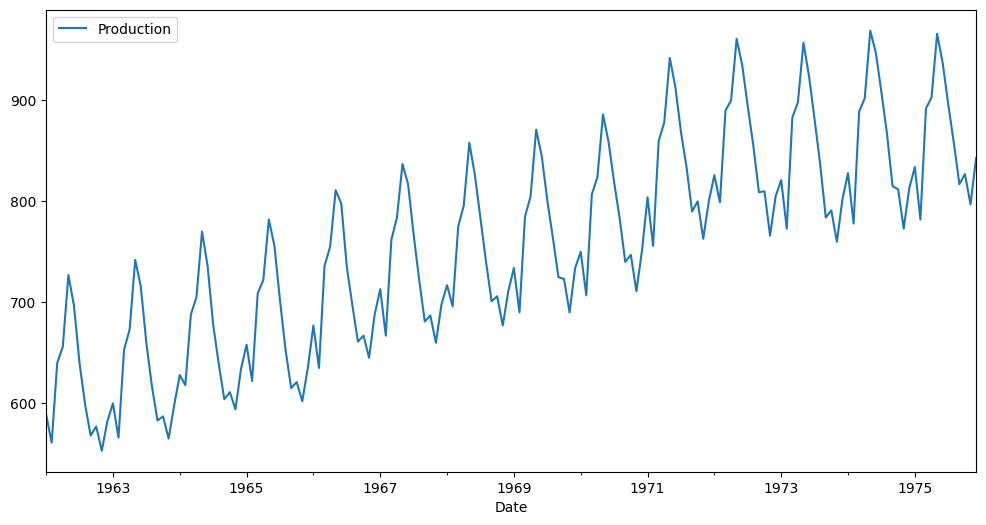

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
results = seasonal_decompose(df['Production'])

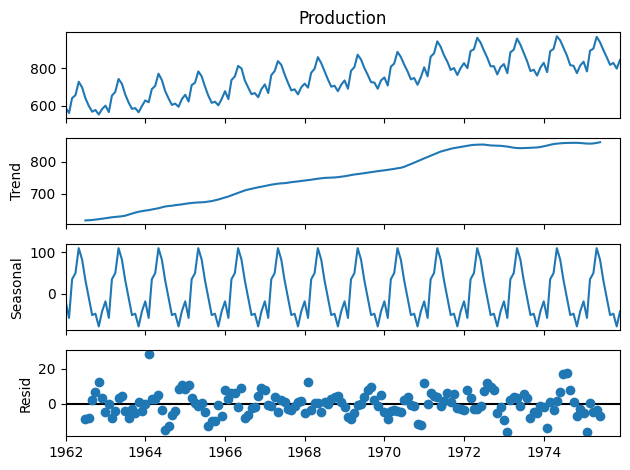

In [10]:
results.plot();

In [11]:
len(df)

168

In [12]:
train = df.iloc[:148]
test = df.iloc[148:]

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [14]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
scaled_train[:10]

array([[0.08823529],
       [0.01960784],
       [0.21323529],
       [0.25245098],
       [0.42647059],
       [0.35294118],
       [0.21323529],
       [0.1127451 ],
       [0.03676471],
       [0.05882353]])

In [17]:
from keras.preprocessing.sequence import TimeseriesGenerator

123 4 --> 345 6 --> 456 7 --> 567 8 --> 567 9

In [20]:
# define generator

# picking 3 batches at a time to predict the next batch
n_input = 3
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size =1)

In [25]:
X, y = generator[144]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.67401961 0.55147059 0.82352941]
Predict this y: 
 [[0.85539216]]


In [28]:
#Doing the same thing but now for 12 months

n_inputs = 12

generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_inputs, batch_size = 1)

In [29]:
X, y = generator[0]

print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08823529 0.01960784 0.21323529 0.25245098 0.42647059 0.35294118
 0.21323529 0.1127451  0.03676471 0.05882353 0.         0.07107843]
Predict this y: 
 [[0.11519608]]


In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
#Defining the mdel

model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape = (n_inputs, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
#Fitting the model on the generator

model.fit(generator, epochs = 50)

Epoch 1/50
136/136 [==============================] - 5s 17ms/step - loss: 0.0500
Epoch 2/50
136/136 [==============================] - 3s 19ms/step - loss: 0.0213
Epoch 3/50
136/136 [==============================] - 3s 22ms/step - loss: 0.0156
Epoch 4/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0122
Epoch 5/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0102
Epoch 6/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 7/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0084
Epoch 8/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0079
Epoch 9/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0065
Epoch 10/50
136/136 [==============================] - 2s 13ms/step - loss: 0.0046
Epoch 11/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0040
Epoch 12/50
136/136 [==============================] - 1s 9ms/step - loss: 0.0045
Epoch 13/50
136/136 [

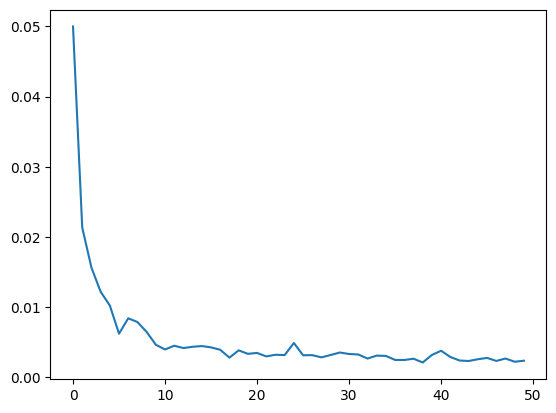

In [36]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch);

In [35]:
len(loss_per_epoch)

50

### Make Predictions with LSTM

In [37]:
last_train_batch = scaled_train[-12:] #Using the last 12 months data

In [41]:
last_train_batch = last_train_batch.reshape((1, n_inputs, n_features))

In [42]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 207ms/step


array([[0.9909726]], dtype=float32)

In [43]:
scaled_test[0]

array([1.01960784])

In [45]:
test_predictions = []

first_eval_batch = scaled_train[-12:]
current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


In [46]:
test_predictions

[array([0.9909726], dtype=float32),
 array([0.96958035], dtype=float32),
 array([0.87978435], dtype=float32),
 array([0.75589037], dtype=float32),
 array([0.6273664], dtype=float32),
 array([0.6047033], dtype=float32),
 array([0.5550875], dtype=float32),
 array([0.61368364], dtype=float32),
 array([0.68223006], dtype=float32),
 array([0.64976174], dtype=float32),
 array([0.8604249], dtype=float32),
 array([0.93559283], dtype=float32),
 array([1.0243253], dtype=float32),
 array([1.0220798], dtype=float32),
 array([0.9453043], dtype=float32),
 array([0.81400454], dtype=float32),
 array([0.67523974], dtype=float32),
 array([0.62524444], dtype=float32),
 array([0.5824176], dtype=float32),
 array([0.6137409], dtype=float32)]

In [47]:
test.head()

,Production
Date,
1974-05-01,969
1974-06-01,947
1974-07-01,908
1974-08-01,867
1974-09-01,815


In [48]:
true_predictions = scaler.inverse_transform(test_predictions)

In [49]:
test['Predictions'] = true_predictions

<ipython-input-49-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [50]:
test.tail()

,Production,Predictions
Date,,
1975-08-01,858,885.113853
1975-09-01,817,828.497815
1975-10-01,827,808.099731
1975-11-01,797,790.626384
1975-12-01,843,803.406296


<Axes: xlabel='Date'>

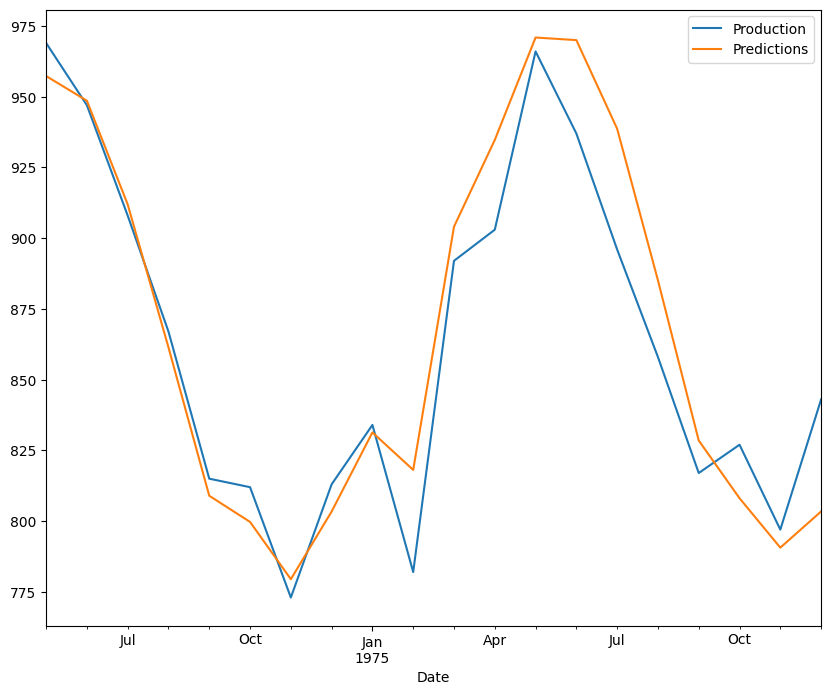

In [51]:
test.plot(figsize=(10,8))

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

20.90244008616313
